# 0.0 Imports

In [3]:
import re
import nltk
import html
import spacy
import pandas            as pd

from nltk.corpus       import stopwords
from nltk.tokenize     import word_tokenize

from collections       import Counter

from bs4               import BeautifulSoup

import matplotlib.pyplot as plt

from striprtf.striprtf import rtf_to_text

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese'))
nlp = spacy.load("pt_core_news_lg")


[nltk_data] Downloading package punkt to /home/jz1nn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jz1nn/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jz1nn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 0.1 Functions

Clean and extract text

In [4]:
def clean_medical_text(text):
    text = str(text)
    
    text = re.sub(r'&#x200B;|\\\'[a-z0-9]{2,3}', ' ', text)
    
    if text.strip().lower().startswith('<html'):
        soup = BeautifulSoup(text, 'html.parser')
        cleaned = soup.get_text(separator=' ', strip=True)
        
    elif text.strip().startswith('{\\rtf'):
        try:
            cleaned = rtf_to_text(text)
        except:
            cleaned = text
    else:
        cleaned = text
    
    cleaned = re.sub(r'\\[a-z]+|[\{\}<>]', ' ', cleaned)
    
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()
    
    patterns = [
        r'ANAMNESE\s?-\s?CENTRO CLÍNICO',
        r'EVOLUÇÃO DE ENFERMAGEM',
        r'ANOTAÇÃO DE ENFERMAGEM',
        r'Exame Físico:',
        r'Sinais Vitais:',
        r'Hipótese Diagnóstica:',
        r'Conduta:'
    ]
    
    for pattern in patterns:
        cleaned = re.sub(pattern, '', cleaned, flags=re.IGNORECASE)
    
    return cleaned.strip()

Tokenize and remove stop words

In [5]:
def process_text(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc 
        if not token.is_stop 
        and not token.is_punct 
        and token.text.strip() != ''
    ]
    return tokens

Extract terms

In [6]:
def extract_terms(texto):
    # Comorbidades (AP: Antecedentes Pessoais)
    comorbidades = re.findall(r"AP:\s*(.*?)(?=\n|$)", texto, re.IGNORECASE)
    comorbidades = [term.strip() for term in re.split(r"[/,;]", comorbidades[0])] if comorbidades else []

    # Queixas Principais
    queixas = re.findall(r"Queixa Principal:\s*(.*?)(?=\n|$)", texto, re.IGNORECASE)
    queixas = [term.strip() for term in re.split(r"[,;.]", queixas[0])] if queixas else []

    # Ações Médicas (CD: Conduta)
    acoes = re.findall(r"CD:\s*(.*?)(?=\n|$)", texto, re.IGNORECASE)
    acoes = [term.strip() for term in re.split(r"[,;.]", acoes[0])] if acoes else []

    return comorbidades, queixas, acoes

Extract patterns

In [7]:
def extract_patterns(text, pattern):
    if pd.isnull(text):
        return []
    matches = re.findall(pattern, text, flags=re.IGNORECASE)
    return matches

# 1.0 Data analysis

## 1.1 Descriptive analysis

In [8]:
df = pd.read_csv('sample_teste_nlp.csv')
print(df.head())
print(f"\nTotal de registros: {len(df)}")
print(f"Colunas disponíveis: {df.columns.tolist()}")

   patient_id   age sex             ehr_date  \
0      341196  82.0   M  2023-09-05 10:23:37   
1     4309949  32.0   F  2023-11-01 12:10:59   
2      404932  91.0   M  2023-09-16 07:24:02   
3     5603035  53.0   F  2024-08-03 06:56:48   
4      154876  27.0   M  2023-11-05 04:58:01   

                                                text  
0  <html tasy="html5"><body><p style="text-align:...  
1  <html tasy="html5"><body><p style="text-align:...  
2  {\rtf1\ansi\ansicpg1252{\fonttbl{\f0\fnil\fcha...  
3          RET 6 MESES PARA AVALIAÇÃO CALCIO + VIT D  
4  {\rtf1\ansi\ansicpg1252{\fonttbl{\f0\fnil\fcha...  

Total de registros: 6834
Colunas disponíveis: ['patient_id', 'age', 'sex', 'ehr_date', 'text']


In [9]:
print("\nDistribuição por sexo:")
print(df['sex'].value_counts())
print("\nDistribuição etária:")
print(df['age'].describe())


Distribuição por sexo:
sex
F    3986
M    2788
I      60
Name: count, dtype: int64

Distribuição etária:
count    6833.000000
mean       49.242646
std        21.958364
min         2.000000
25%        33.000000
50%        49.000000
75%        67.000000
max       101.000000
Name: age, dtype: float64


In [10]:
html_docs = df['text'].str.startswith('<html').sum()
rtf_docs = df['text'].str.startswith('{\\rtf').sum()
plain_text = len(df) - html_docs - rtf_docs

print(f"\nTipos de documentos:\n- HTML: {html_docs}\n- RTF: {rtf_docs}\n- Texto simples: {plain_text}")


Tipos de documentos:
- HTML: 4253
- RTF: 1852
- Texto simples: 729


## 1.2 Clean data

In [11]:
df['clean_text'] = df['text'].apply(clean_medical_text)

In [12]:
df['processed_text'] = df['clean_text'].apply(process_text)

In [13]:
df[["comorbidades", "queixas", "acoes_medicas"]] = df["clean_text"].apply(
    lambda x: pd.Series(extract_terms(x))
)

In [14]:
df[['clean_text', 'processed_text', 'comorbidades', 'queixas', 'acoes_medicas']].sample(5)

,clean_text,processed_text,comorbidades,queixas,acoes_medicas
4671,ANOTA O DE ENFERMAGEM 23:29 HS RECEBO EM SALA ...,"[anotar, enfermagem, 23:29, hs, receber, sala,...",[],[],[]
2563,ANOTA O DE ENFERMAGEM S 10:55HRS ADMITIDO CRIA...,"[anotar, enfermagem, s, 10:55hrs, admitido, cr...",[],[],[]
6481,Ficha de Avaliação Multidisciplinar Serviço so...,"[ficha, avaliação, multidisciplinar, serviço, ...",[],[],[]
5725,"# RETORNO DE TRATAMENTO COM ISOTRETINOÍNA, REF...","[retorno, tratamento, isotretinoína, referir, ...",[],[],[]
3134,"ANAMNESE DOR EM ESCÁPULA ESQUERDA, QUE IRRADIA...","[anamnese, dor, escápula, esquerdo, irradiar, ...",[],[],[]


In [15]:
df_limpo = df.copy()

df_limpo.drop(columns=['text'], inplace=True)
df_limpo.to_csv('teste_limpo.csv', index=False)

## 1.3 Medical terms


Frequência de Comorbidades:
[('has', 1438), ('dm', 1195), ('iam', 518), ('tvp', 372), ('obesidade', 225), ('covid', 208), ('drc', 198), ('avc', 176), ('dlp', 159), ('dpoc', 101), ('hiv', 91), ('icc', 75), ('tep', 46), ('irc', 28), ('tag', 24), ('lupus', 6)]

Frequência de Ações Médicas:
[('exame', 2122), ('prescrição', 697), ('tc', 631), ('cirurgia', 626), ('usg', 609), ('internação', 507), ('pcr', 478), ('ecg', 400), ('rx', 306), ('tomografia', 123), ('hemograma', 100), ('radiografia', 24), ('ultrassom', 9)]

Frequência de Queixas:
[('dor', 2470), ('febre', 475), ('desconforto', 193), ('vômito', 74), ('náusea', 52), ('tontura', 36), ('falta de ar', 22), ('cansaço', 18)]


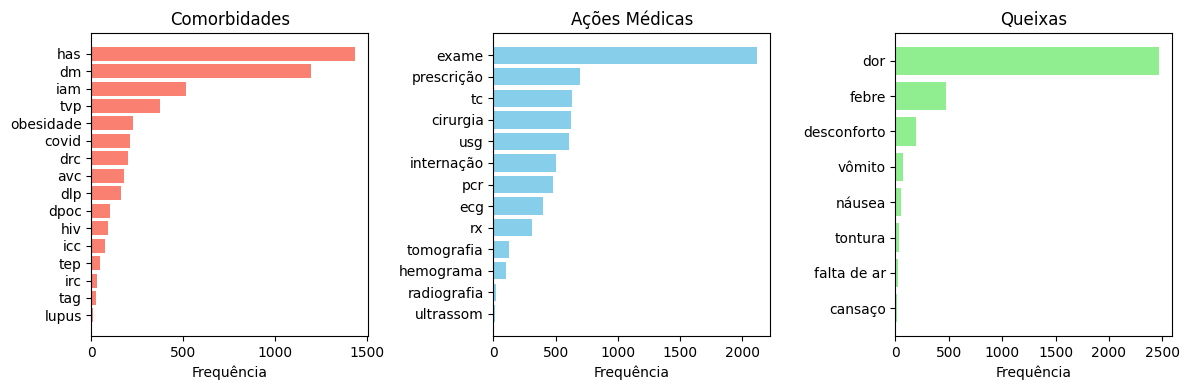

In [16]:
patterns = {
    "comorbidades": r"\b(HAS|DM|DPOC|DLP|IRC|IAM|AVC|TEP|TVP|DRC|HIV|COVID|LUPUS|OBESIDADE|TAG|ICC)\b",
    "acoes_medicas": r"\b(RX|TC|ECG|USG|PCR|hemograma|cirurgia|exame|internação|prescrição|radiografia|tomografia|ultrassom)\b",
    "queixas": r"\b(dor|febre|náusea|vômito|falta de ar|cansaço|tontura|desconforto)(?:.*?)(?=\n|;|$)"
}

df['clean_text'] = df['clean_text'].str.lower().str.strip()


df['comorbidades_encontradas'] = df['clean_text'].apply(lambda x: extract_patterns(x, patterns["comorbidades"]))
df['acoes_medicas_encontradas'] = df['clean_text'].apply(lambda x: extract_patterns(x, patterns["acoes_medicas"]))
df['queixas_encontradas'] = df['clean_text'].apply(lambda x: extract_patterns(x, patterns["queixas"]))

contador_comorbidades = Counter([termo for sublista in df['comorbidades_encontradas'] for termo in sublista])
contador_acoes_medicas = Counter([termo for sublista in df['acoes_medicas_encontradas'] for termo in sublista])
contador_queixas = Counter([termo for sublista in df['queixas_encontradas'] for termo in sublista])

sorted_comorbidades = contador_comorbidades.most_common()
sorted_acoes_medicas = contador_acoes_medicas.most_common()
sorted_queixas = contador_queixas.most_common()

print("\nFrequência de Comorbidades:")
print(sorted_comorbidades)
print("\nFrequência de Ações Médicas:")
print(sorted_acoes_medicas)
print("\nFrequência de Queixas:")
print(sorted_queixas)

# Plot
plt.figure(figsize=(12, 4))

# Comorbidades
terms, counts = zip(*sorted_comorbidades)
plt.subplot(1, 3, 1)
plt.barh(terms, counts, color='salmon')
plt.gca().invert_yaxis()
plt.title("Comorbidades")
plt.xlabel("Frequência")

# Ações Médicas
terms, counts = zip(*sorted_acoes_medicas)
plt.subplot(1, 3, 2)
plt.barh(terms, counts, color='skyblue')
plt.gca().invert_yaxis()
plt.title("Ações Médicas")
plt.xlabel("Frequência")

# Queixas
terms, counts = zip(*sorted_queixas)
plt.subplot(1, 3, 3)
plt.barh(terms, counts, color='lightgreen')
plt.gca().invert_yaxis()
plt.title("Queixas")
plt.xlabel("Frequência")

plt.tight_layout()
plt.show()

## 1.4 Content Analysis

In [17]:
top_5_comorbidades = sorted_comorbidades[:5]
top_5_acoes_medicas = sorted_acoes_medicas[:5]
top_5_queixas = sorted_queixas[:5]

print("\nTop 5 Comorbidades:")
for term, count in top_5_comorbidades:
    print(f"{term.upper()}: {count} ocorrências")

print("\nTop 5 Ações Médicas:")
for term, count in top_5_acoes_medicas:
    print(f"{term.upper()}: {count} ocorrências")

print("\nTop 5 Queixas:")
for term, count in top_5_queixas:
    print(f"{term.upper()}: {count} ocorrências")


Top 5 Comorbidades:
HAS: 1438 ocorrências
DM: 1195 ocorrências
IAM: 518 ocorrências
TVP: 372 ocorrências
OBESIDADE: 225 ocorrências

Top 5 Ações Médicas:
EXAME: 2122 ocorrências
PRESCRIÇÃO: 697 ocorrências
TC: 631 ocorrências
CIRURGIA: 626 ocorrências
USG: 609 ocorrências

Top 5 Queixas:
DOR: 2470 ocorrências
FEBRE: 475 ocorrências
DESCONFORTO: 193 ocorrências
VÔMITO: 74 ocorrências
NÁUSEA: 52 ocorrências


# <font color='red'> 1.0.1 Conclusion of descriptive analysis </font>

## Análise Descritiva dos Documentos

## 1. Total de Registros e Colunas Disponíveis
- **Total de registros:** 6834
- **Colunas disponíveis:** `['patient_id', 'age', 'sex', 'ehr_date', 'text']`

## 2. Distribuição por Sexo
- **Feminino (F):** 3986 registros
- **Masculino (M):** 2788 registros
- **Indefinido (I):** 60 registros

## 3. Distribuição Etária
- **Média de idade:** 49.24 anos
- **Desvio padrão:** 21.96 anos
- **Idade mínima:** 2 anos
- **Idade máxima:** 101 anos

## 4. Termos Mais Frequentes

### Top 5 Comorbidades:
- **HAS:** 1438 ocorrências
- **DM:** 1195 ocorrências
- **IAM:** 518 ocorrências
- **TVP:** 372 ocorrências
- **OBESIDADE:** 225 ocorrências

### Top 5 Ações Médicas:
- **EXAME:** 2122 ocorrências
- **PRESCRIÇÃO:** 697 ocorrências
- **TC:** 631 ocorrências
- **CIRURGIA:** 626 ocorrências
- **USG:** 609 ocorrências

### Top 5 Queixas:
- **DOR:** 2470 ocorrências
- **FEBRE:** 475 ocorrências
- **DESCONFORTO:** 193 ocorrências
- **VÔMITO:** 74 ocorrências
- **NÁUSEA:** 52 ocorrências

## 5. Tipos de Documentos
- **HTML:** 4253 documentos
- **RTF:** 1852 documentos
- **Texto simples:** 729 documentos

## Conclusões

### Forma de Escrita dos Documentos:
- Os documentos são escritos em diferentes formatos: HTML, RTF e texto simples.

### Tipos Diferentes de Documentos:
- A maioria dos documentos está em formato HTML (4253), seguido por RTF (1852) e texto simples (729).

### Alterações Comuns Entre os Pacientes:
- A análise dos termos mais frequentes revela que muitos pacientes apresentam condições como alergias, dores, cefaleia, hipertensão arterial sistêmica (HAS), diabetes mellitus (DM), e são submetidos a exames e cirurgias.

# 2.0 Pipeline

## 2.1 Data pre-processing

In [18]:
import re
import html
import spacy
import pandas as pd
from bs4 import BeautifulSoup
from striprtf.striprtf import rtf_to_text

nlp = spacy.load("pt_core_news_lg")

abreviacoes = {
    r'\bHAS\b': 'Hipertensão Arterial Sistêmica',
    r'\bDM\b': 'Diabetes Mellitus',
    r'\bIRC\b': 'Insuficiência Renal Crônica',
    r'\bIAM\b': 'Infarto Agudo do Miocárdio',
    r'\bPCR\b': 'Reação em Cadeia da Polimerase',
    r'\bRX\b': 'Raio-X',
    r'\bTC\b': 'Tomografia Computadorizada',
    r'\bUSG\b': 'Ultrassonografia',
    r'\bAVC\b': 'Acidente Vascular Cerebral',
    r'\bSAT\b': 'Saturação de Oxigênio',
    r'\bFR\b': 'Frequência Respiratória',
    r'\bDPOC\b': 'Doença Pulmonar Obstrutiva Crônica',
    r'\bDLP\b': 'Dislipidemia',
    r'\bTEP\b': 'Tromboembolismo Pulmonar',
    r'\bTVP\b': 'Trombose Venosa Profunda',
    r'\bDRC\b': 'Doença Renal Crônica',
    r'\bHIV\b': 'Vírus da Imunodeficiência Humana',
    r'\bCOVID\b': 'Coronavírus',
    r'\bLUPUS\b': 'Lúpus Eritematoso Sistêmico',
    r'\bOBESIDADE\b': 'Obesidade',
    r'\bTAG\b': 'Transtorno de Ansiedade Generalizada',
    r'\bICC\b': 'Insuficiência Cardíaca Congestiva',
    r'\bECG\b': 'Eletrocardiograma',
    r'\bPCR\b': 'Proteína C-Reativa',
    r'\bFR:\b': 'Frequência Respiratória',
}

def expandir_abreviacoes(texto):
    for abrev, exp in abreviacoes.items():
        texto = re.sub(abrev, exp, texto, flags=re.IGNORECASE)
    return texto

def clean_medical_text(text):
    text = str(text)
    
    if text.strip().lower().startswith('<html'):
        soup = BeautifulSoup(text, 'html.parser')
        text = soup.get_text(separator=' ', strip=True)
    elif text.strip().startswith('{\\rtf'):
        try: text = rtf_to_text(text)
        except: pass
    
    text = re.sub(r'\b\d+\b', ' ', text)
    text = re.sub(r'[^\w\s]|_', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    headers = [
        r'ANAMNESE\s?-\s?CENTRO CLÍNICO',
        r'EVOLUÇÃO DE ENFERMAGEM',
        r'ANOTAÇÃO DE ENFERMAGEM',
        r'Exame Físico:',
        r'Sinais Vitais:',
        r'Hipótese Diagnóstica:',
        r'Conduta:',
        r'anamnese.*centro cl[ií]nico', 
        r'evolu[cç][aã]o de enfermagem',
        r'sinais vitais:',
    ]
    for header in headers:
        text = re.sub(header, '', text, flags=re.IGNORECASE)
    
    return text

def preprocess_data(df):
    df['clean_text'] = df['text'].apply(clean_medical_text)
    df['preprocessed'] = df['clean_text']
    return df[['patient_id', 'age', 'sex', 'ehr_date', 'preprocessed']]

if __name__ == "__main__":
    df = pd.read_csv('sample_teste_nlp.csv')
    processed_df = preprocess_data(df)
    processed_df.to_csv('dados_preprocessados.csv', index=False)

## 2.2 Entity annotation

In [21]:
MEDICAMENTOS = {
    'paracetamol', 'dipirona', 'omeprazol', 'losartana', 'sinvastatina',
    'metformina', 'cefalexina', 'azitromicina', 'levotiroxina',
    'hidroclorotiazida', 'atenolol', 'insulina', 'dexametasona'
}

EXAMES = {
    'raio-x', 'raiox', 'tomografia computadorizada', 'ultrassonografia', 
    'eletrocardiograma', 'ressonância', 'ressonancia', 'ressonância magnético', 'colonoscopia',
    'endoscopia', 'glicemia jejum', 'proteína c-reativa',
    'hemograma completo'
}

DOENÇAS = {
    'hipertensão arterial sistêmica', 'diabetes mellitus', 
    'insuficiência renal crônica', 'infarto agudo miocárdio',
    'trombose venosa profunda', 'doença pulmonar obstrutiva crônica',
    'lúpus eritematoso sistêmico', 'obesidade grau',
    'insuficiência cardíaca congestiva', 'acidente vascular cerebral'
}

def label_entities(text):
    text_lower = text.lower()
    entities = {'medicamentos': [], 'exames': [], 'doencas': []}
    
    for med in MEDICAMENTOS:
        if re.search(r'\b' + re.escape(med) + r'\b', text_lower):
            entities['medicamentos'].append(med)
    
    for exame in EXAMES:
        if re.search(r'\b' + re.escape(exame) + r'\b', text_lower):
            entities['exames'].append(exame)
    
    for doenca in DOENÇAS:
        if re.search(r'\b' + re.escape(doenca) + r'\b', text_lower):
            entities['doencas'].append(doenca)
    
    for key in entities:
        entities[key] = list(set(entities[key]))
    
    return entities

In [22]:
df = pd.read_csv('dados_preprocessados.csv').dropna(subset=['preprocessed'])
df['labels'] = df['preprocessed'].apply(label_entities)

def create_labels_df(df):
    all_meds = sorted(MEDICAMENTOS)
    all_exames = sorted(EXAMES)
    all_doencas = sorted(DOENÇAS)
    
    label_data = []
    for _, row in df.iterrows():
        labels = row['labels']
        label_row = {
            **{f'med_{med}': 1 if med in labels['medicamentos'] else 0 for med in all_meds},
            **{f'exa_{exame}': 1 if exame in labels['exames'] else 0 for exame in all_exames},
            **{f'doe_{doenca}': 1 if doenca in labels['doencas'] else 0 for doenca in all_doencas}
        }
        label_data.append(label_row)
    
    return pd.DataFrame(label_data)

y = create_labels_df(df)
y.to_csv('medical_labels.csv', index=False)
df[['preprocessed']].to_csv('preprocessed_texts.csv', index=False)

## 2.3 BERTimbau

In [24]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

class MedicalDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(self.labels[idx])
        }

df = pd.read_csv('preprocessed_texts.csv').fillna('')
y = pd.read_csv('medical_labels.csv').fillna(0)

X_train, X_val, y_train, y_val = train_test_split(
    df['preprocessed'], 
    y.values, 
    test_size=0.2, 
    random_state=42
)

# Tokenização
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
MAX_LEN = 256
BATCH_SIZE = 16

train_dataset = MedicalDataset(X_train.tolist(), y_train, tokenizer, MAX_LEN)
val_dataset = MedicalDataset(X_val.tolist(), y_val, tokenizer, MAX_LEN)

# Modelo
model = BertForSequenceClassification.from_pretrained(
    'neuralmind/bert-base-portuguese-cased',
    num_labels=y.shape[1],
    problem_type="multi_label_classification"
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

# Treinamento
for epoch in range(3):
    model.train()
    total_loss = 0
    for batch in DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Validação
    model.eval()
    val_preds = []
    with torch.no_grad():
        for batch in DataLoader(val_dataset, batch_size=BATCH_SIZE):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            val_preds.extend(torch.sigmoid(outputs.logits).cpu().numpy())
    
    val_preds = np.array(val_preds) > 0.5
    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {total_loss/len(train_dataset):.4f}")
    print(f"Val F1: {f1_score(y_val, val_preds, average='micro'):.4f}")
    print(f"Val Accuracy: {accuracy_score(y_val, val_preds):.4f}\n")

# Salvar modelo
model.save_pretrained('bertimbau_medical')
tokenizer.save_pretrained('bertimbau_medical')

/home/jz1nn/.pyenv/versions/3.8.20/envs/neuralMed/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/jz1nn/.pyenv/versions/3.8.20/envs/neuralMed/lib/python3.8/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1
Train Loss: 0.0094
Val F1: 0.0000
Val Accuracy: 0.8442

Epoch 2
Train Loss: 0.0024
Val F1: 0.0000
Val Accuracy: 0.8442

Epoch 3
Train Loss: 0.0021
Val F1: 0.0000
Val Accuracy: 0.8442



('bertimbau_medical/tokenizer_config.json',
 'bertimbau_medical/special_tokens_map.json',
 'bertimbau_medical/vocab.txt',
 'bertimbau_medical/added_tokens.json')

In [25]:
def predict(text):
    model = BertForSequenceClassification.from_pretrained('bertimbau_medical')
    tokenizer = BertTokenizer.from_pretrained('bertimbau_medical')
    model.eval()
    
    inputs = tokenizer(text, return_tensors='pt', max_length=256, padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    
    probs = torch.sigmoid(outputs.logits).numpy()[0]
    return {label: float(prob) for label, prob in zip(y.columns, probs)}

print(predict("Paciente com diabetes mellitus e hipertensão arterial sistêmica"))

{'med_atenolol': 0.009733360260725021, 'med_azitromicina': 0.005908183753490448, 'med_cefalexina': 0.0054066842421889305, 'med_dexametasona': 0.010420733131468296, 'med_dipirona': 0.043608471751213074, 'med_hidroclorotiazida': 0.004914321471005678, 'med_insulina': 0.015650421380996704, 'med_levotiroxina': 0.009224392473697662, 'med_losartana': 0.03171457722783089, 'med_metformina': 0.009520219638943672, 'med_omeprazol': 0.010170310735702515, 'med_paracetamol': 0.006938197650015354, 'med_sinvastatina': 0.012064163573086262, 'exa_colonoscopia': 0.008152920752763748, 'exa_eletrocardiograma': 0.00593298114836216, 'exa_endoscopia': 0.006892920471727848, 'exa_glicemia jejum': 0.003502330044284463, 'exa_hemograma completo': 0.0033919860143214464, 'exa_proteína c-reativa': 0.004791334271430969, 'exa_raio-x': 0.0036140242591500282, 'exa_raiox': 0.00424482487142086, 'exa_ressonancia': 0.0045749107375741005, 'exa_ressonância': 0.00517435884103179, 'exa_ressonância magnético': 0.003946156706660986

# 3.0 Prompt

In [26]:
def prompt_extraction(text, prompt_type='medicamentos'):
    # Pré-processamento
    cleaned_text = clean_medical_text(text)
    expanded_text = expandir_abreviacoes(cleaned_text)
    doc = nlp(expanded_text)
    
    result = {'texto_original': text, 'texto_processado': expanded_text}
    
    # Medicamentos com dosagem
    if prompt_type == 'medicamentos':
        medicamentos = []
        for ent in doc.ents:
            if ent.label_ == "MEDICAMENTO":
                dose = re.search(r'\d+\s*mg|ml|UI|%', ent.text)
                freq = re.search(r'\d+/\d+\s*horas?|\d+x\s*ao\s*dia', ent.text)
                medicamentos.append({
                    'nome': ent.text,
                    'dose': dose.group(0) if dose else None,
                    'frequencia': freq.group(0) if freq else None
                })
        result['medicamentos'] = medicamentos
    
    # Doenças e Sintomas
    elif prompt_type == 'doencas':
        doencas = []
        for ent in doc.ents:
            if ent.label_ == "DOENÇA":
                sintomas = []
                for token in ent.root.children:
                    if token.dep_ in ("nmod", "amod") and token.text.lower() not in EXAMES:
                        sintomas.append(token.text)
                doencas.append({
                    'doenca': ent.text,
                    'sintomas': list(set(sintomas)) if sintomas else None
                })
        result['doencas'] = doencas
    
    # Exames
    elif prompt_type == 'exames':
        exames = []
        for sent in doc.sents:
            if any(exame in sent.text.lower() for exame in EXAMES):
                data = re.search(r'\d{2}/\d{2}/\d{4}', sent.text)
                detalhes = re.search(r'(com|sem|resultado:)\s+([^\.]+)', sent.text)
                exames.append({
                    'exame': next((ex for ex in EXAMES if ex in sent.text.lower()), None),
                    'data': data.group(0) if data else None,
                    'detalhes': detalhes.group(2) if detalhes else None
                })
        result['exames'] = exames
    
    # Expansão de Abreviações
    elif prompt_type == 'abreviacoes':
        matches = []
        for abrev in abreviacoes:
            if re.search(abrev, text, flags=re.IGNORECASE):
                matches.append({
                    'abreviacao': re.search(abrev, text).group(0),
                    'expandido': abreviacoes[abrev]
                })
        result['abreviacoes'] = matches
    
    # Hipóteses Diagnósticas
    elif prompt_type == 'diagnostico':
        prediction = predict(expanded_text)
        diagnostico = {
            'doencas_identificadas': [k.replace('doe_', '') for k, v in prediction.items() if k.startswith('doe_') and v > 0.5],
            'medicamentos_prescritos': [k.replace('med_', '') for k, v in prediction.items() if k.startswith('med_') and v > 0.5],
            'exames_solicitados': [k.replace('exa_', '') for k, v in prediction.items() if k.startswith('exa_') and v > 0.5]
        }
        result['diagnostico'] = diagnostico
    
    return result



In [28]:
import json
from spacy.pipeline import EntityRuler

#ruler = nlp.add_pipe("entity_ruler", before="ner")

patterns = [
    {"label": "MEDICAMENTO", "pattern": [{"LOWER": {"IN": list(MEDICAMENTOS)}}]},
    {"label": "DOENÇA", "pattern": [{"LOWER": {"IN": list(DOENÇAS)}}]},
    {"label": "EXAME", "pattern": [{"LOWER": {"IN": list(EXAMES)}}]},
    # Padrão para dosagens (ex: 500mg, 2x ao dia)
    {"label": "DOSAGEM", "pattern": [{"TEXT": {"REGEX": r"\d+\s*(mg|ml|UI|%)"}}]},
    {"label": "FREQUENCIA", "pattern": [{"TEXT": {"REGEX": r"\d+/\d+\s*horas?|\d+x\s*ao\s*dia"}}]}
]

ruler.add_patterns(patterns)

texto_exemplo = """
Paciente com DM e HAS. Apresenta glicemia de 250 mg/dL. 
Prescrito Metformina 850mg (1x ao dia) e Losartana 50mg.
Solicitar ECG e Hemograma completo.
"""

# Testar prompts
for prompt in ['medicamentos', 'doencas', 'exames', 'abreviacoes', 'diagnostico']:
    print(f"\n=== RESULTADO PARA PROMPT '{prompt.upper()}' ===")
    resultado = prompt_extraction(texto_exemplo, prompt_type=prompt)
    print(json.dumps(resultado, indent=2, ensure_ascii=False))


=== RESULTADO PARA PROMPT 'MEDICAMENTOS' ===
{
  "texto_original": "\nPaciente com DM e HAS. Apresenta glicemia de 250 mg/dL. \nPrescrito Metformina 850mg (1x ao dia) e Losartana 50mg.\nSolicitar ECG e Hemograma completo.\n",
  "texto_processado": "Paciente com Diabetes Mellitus e Hipertensão Arterial Sistêmica Apresenta glicemia de mg dL Prescrito Metformina 850mg 1x ao dia e Losartana 50mg Solicitar Eletrocardiograma e Hemograma completo",
  "medicamentos": [
    {
      "nome": "Metformina",
      "dose": null,
      "frequencia": null
    },
    {
      "nome": "Losartana",
      "dose": null,
      "frequencia": null
    }
  ]
}

=== RESULTADO PARA PROMPT 'DOENCAS' ===
{
  "texto_original": "\nPaciente com DM e HAS. Apresenta glicemia de 250 mg/dL. \nPrescrito Metformina 850mg (1x ao dia) e Losartana 50mg.\nSolicitar ECG e Hemograma completo.\n",
  "texto_processado": "Paciente com Diabetes Mellitus e Hipertensão Arterial Sistêmica Apresenta glicemia de mg dL Prescrito Metformina